In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
#Run it only for the first time
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import itertools
import datetime
from sklearn import metrics
#import keras_metrics

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
from keras.regularizers import L1L2
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Embedding, LSTM, Lambda, Bidirectional, GRU
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/Amrita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading the dataset

In [2]:
train_data = pd.read_csv('train.csv')

#### Data Cleaning

In [3]:
train_data.dropna(inplace=True)

In [4]:
train_data.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [5]:
pd.value_counts(train_data.is_duplicate)

0    255024
1    149263
Name: is_duplicate, dtype: int64

### Data Preparation

In [6]:
# Load vocabulary from training and test set

#Loading Stopwords
stops = set(stopwords.words('english'))
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower() #lowercase words

    # Clean the text - remove special characters, numbers, punctuations,non-standard words
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split() #Split into words

    return text

# Vocabulary building
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

questions_cols = ['question1', 'question2']

# Iterate over the questions in dataset
for dataset in [train_data]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops: #and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)

## Jaccard similiarity

In [0]:
def get_jaccard_sim(str): 
    a = set(str['question1'].split()) 
    b = set(str['question2'].split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
a = train_data.drop(columns=['id','qid1','qid2','is_duplicate'])
a.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [0]:
train_data['jaccard_sim'] = a.apply(get_jaccard_sim, axis=1)

In [0]:
train_data['pred_jac_sim'] = (train_data['jaccard_sim']>=0.5)

In [0]:
metrics.confusion_matrix(train_data['is_duplicate'], train_data['pred_jac_sim'])

array([[212657,  42367],
       [101085,  48178]])

In [0]:
metrics.accuracy_score(train_data['is_duplicate'], train_data['pred_jac_sim'])

0.6451728598742972

In [0]:
metrics.recall_score(train_data['is_duplicate'], train_data['pred_jac_sim'])

0.3227725558242833

In [0]:
metrics.precision_score(train_data['is_duplicate'], train_data['pred_jac_sim'])

0.532089016511127

In [0]:
metrics.f1_score(train_data['is_duplicate'], train_data['pred_jac_sim'])

0.40180477715505736

## Cosine similiarity

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Bring in standard stopwords
stopWords = stopwords.words('english')

# Set up the vectoriser, passing in the stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=stopWords)

# Apply the vectoriser to the training set
tfidf = tfidf_vectorizer.fit(vocabulary)
tfidf_matrix_1 = tfidf_vectorizer.transform(a['question1'])
tfidf_matrix_2 = tfidf_vectorizer.transform(a['question2'])

In [0]:
cos_sim=[]
for i in range(tfidf_matrix_2.shape[0]):
    if i%1000 == 0:
      print(i)
    cos_sim.append(cosine_similarity(tfidf_matrix_1[i,:], tfidf_matrix_2[i,:]))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [0]:
cs=[]
for i in range(tfidf_matrix_2.shape[0]):
    cs.append(cos_sim[i][0][0])

In [0]:
train_data['cos_sim'] = cs

In [0]:
train_data['pred_cos_sim'] = (train_data['cos_sim'] >= 0.5)

In [0]:
metrics.confusion_matrix(train_data['is_duplicate'], train_data['pred_cos_sim'])

array([[147547, 107477],
       [ 30030, 119233]])

In [0]:
metrics.accuracy_score(train_data['is_duplicate'], train_data['pred_cos_sim'])

0.6598777601060632

In [0]:
metrics.recall_score(train_data['is_duplicate'], train_data['pred_cos_sim'])

0.7988114938062346

In [0]:
metrics.precision_score(train_data['is_duplicate'], train_data['pred_cos_sim'])

0.525927396233073

In [0]:
metrics.f1_score(train_data['is_duplicate'], train_data['pred_cos_sim'])

0.6342636306330508

# Deep Learning Models

## Preparing Embeddings 

In [8]:
#Embeddings matrix

embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

## Siamese LSTM/Bidirectional GRU

### Data Sampling

In [ ]:
train_data_we = train_data.sample(350000)

#### Train test validation split & Zero Padding

In [24]:
max_seq_length = max(train_data_we.question1.map(lambda x: len(x)).max(),
                     train_data_we.question2.map(lambda x: len(x)).max())
                     
                     #test_data.question1.map(lambda x: len(x)).max(),
                     #test_data.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 50000
test_size = 25000
training_size = len(train_data_we) - validation_size

X = train_data_we[questions_cols]
Y = train_data_we['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

X_validation, X_test, Y_validation, Y_test = train_test_split(X_validation, Y_validation, test_size=test_size)

# Split to dicts
X_train_we = {'left': X_train.question1, 'right': X_train.question2}
X_validation_we = {'left': X_validation.question1, 'right': X_validation.question2}
X_test_we = {'left': X_test.question1, 'right': X_test.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = Y_test.values

# Zero padding
for dataset, side in itertools.product([X_train_we, X_validation_we, X_test_we], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train_we['left'].shape == X_train_we['right'].shape
assert len(X_train_we['left']) == len(Y_train)

## Model definition

### Combining Logic - Euclidean Distance and Angle with LSTM

In [ ]:
from keras.layers import Multiply
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def dot_prod(vects):
    x,y = vects
    return K.sum(x*y, axis=1, keepdims=True)

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, 
                            weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)


left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)


# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: euclidean_distance([x[0], x[1]]),
                         output_shape=lambda x: (x[0][0], 1))([left_output, right_output])


malstm_angle = Lambda(function=lambda x: dot_prod([x[0], x[1]]),
                         output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model

c = Concatenate(axis=1)([malstm_distance, malstm_angle])
d1 = Dense(32)(c)
y1 = Dense(1,  activation='sigmoid')(d1)


malstm = Model([left_input, right_input], y1)

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(clipnorm=gradient_clipping_norm)

malstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                        keras_metrics.precision(), 
                                                                        keras_metrics.recall()])         

# Start training
training_start_time = time()

### Combining Logic - Concatenation with LSTM

In [ ]:
from keras.layers import Multiply
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, 
                            weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)
                   #,return_sequences=True)
#shared_lstm_1 = LSTM(n_hidden)


left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

#left_output_1 = shared_lstm_1(left_output)
#right_output_1 = shared_lstm_1(right_output)

# Pack it all up into a model
c = Concatenate(axis=-1)([left_output, right_output])
#y = Dense(32,  activation='relu')(c)
y1 = Dense(1,  activation='sigmoid')(c)

malstm = Model([left_input, right_input], y1)

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(clipnorm=gradient_clipping_norm)

malstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                        keras_metrics.precision(), 
                                                                        keras_metrics.recall()])
              
# Start training
training_start_time = time()

### Combining Logic - Manhattan Distance with Bidirectional GRU

In [25]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 15

def exponent_neg_manhattan_distance(left, right):
   ''' Helper function for the similarity estimate of the LSTMs outputs'''
   return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

#For Custom-word Embeddings set trainable = True
embedding_layer = Embedding(len(embeddings), embedding_dim, 
                           weights=[embeddings], input_length=max_seq_length, trainable=True)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = Bidirectional(GRU(n_hidden, kernel_regularizer=regularizers.l2(0.005)))

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adam optimizer, with gradient clipping by norm
optimizer = Adam(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

In [26]:
malstm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 105)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 105)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 105, 300)     25756500    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 100)          105300      embedding_4[0][0]                
          

### Perform Early Stopping

In [27]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.001, patience=2)

In [28]:
#malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
 #                           validation_data=([X_validation['left'], X_validation['right']], Y_validation), 
  #                          callbacks=[early_stopping])

malstm_trained = malstm.fit([X_train_we['left'], X_train_we['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation_we['left'], X_validation_we['right']], Y_validation),
                            callbacks=[early_stopping])

Train on 300000 samples, validate on 25000 samples
Epoch 1/15
300000/300000 [==============================] - 2784s 9ms/step - loss: 0.1874 - acc: 0.7639 - val_loss: 0.1625 - val_acc: 0.7888
Epoch 2/15
300000/300000 [==============================] - 2776s 9ms/step - loss: 0.1431 - acc: 0.8205 - val_loss: 0.1517 - val_acc: 0.8035
Epoch 3/15
300000/300000 [==============================] - 2776s 9ms/step - loss: 0.1295 - acc: 0.8410 - val_loss: 0.1483 - val_acc: 0.8078
Epoch 4/15
300000/300000 [==============================] - 2747s 9ms/step - loss: 0.1217 - acc: 0.8524 - val_loss: 0.1444 - val_acc: 0.8153
Epoch 5/15
300000/300000 [==============================] - 2750s 9ms/step - loss: 0.1161 - acc: 0.8611 - val_loss: 0.1440 - val_acc: 0.8154
Epoch 6/15
300000/300000 [==============================] - 2749s 9ms/step - loss: 0.1118 - acc: 0.8675 - val_loss: 0.1420 - val_acc: 0.8182
Epoch 7/15
300000/300000 [==============================] - 2757s 9ms/step - loss: 0.1084 - acc: 0.8724

### Test Data Prediction

In [30]:
from sklearn import metrics as met

pred = malstm.predict([X_test_we['left'], X_test_we['right']])
pred_prob = pred>=0.5
print(met.accuracy_score(Y_test, pred_prob))
print(met.recall_score(Y_test, pred_prob))
print(met.precision_score(Y_test, pred_prob))
print(met.f1_score(Y_test, pred_prob))

0.82616
0.7531666125365378
0.7710295910451069
0.7619934282584885


### Accuracy Plots

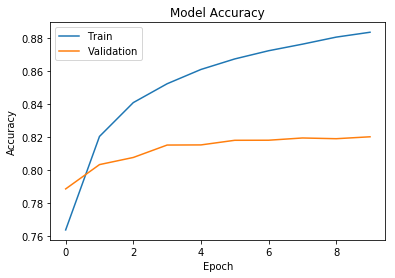

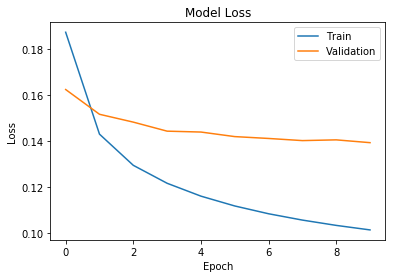

In [31]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()